# Spatio-temporal optimization of groundwater monitoring networks using data-driven sparse sensing methods
#### Using 1D hydrograph data


This notebok enables you to performe the calculations shown in the manuscript: *Ohmer, M., Liesch, A., Wunsch, A., Spatio-temporal optimization of groundwater monitoring networks using data-driven sparse sensing methods*  
Contact: marc.ohmer@kit.edu  
ORCIDs of authors:  
M. Ohmer: [0000-0002-2322-335X](https://orcid.org/0000-0002-2322-335X)  
T. Liesch: [0000-0001-8648-5333](https://orcid.org/0000-0001-8648-5333)  
A. Wunsch:  [0000-0002-0585-9549](https://orcid.org/0000-0002-0585-9549)  

The identical data set is used here. However, well IDs have been anonymized. The well data are publicly available at the web service of the Baden-Wuerttemberg State Office for Environment and Geology https://udo.lubw.baden-wuerttemberg.de/public/

For a detailed description please refer to the manuscript. Please adapt all absolute loading/saving and software paths within the script.

For the optimization we used the pack PySensors: which is a Scikit-learn style Python package for the sparse placement of sensors, either for reconstruction or classification tasks.  
[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.5823616.svg)](https://doi.org/10.5281/zenodo.5823616)  
To run the  Code please download and install the following packages packages:

In [1]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors
import contextily as ctx
import pysensors as ps

In [2]:
#Define data path 
os.chdir(r'C:\Users\Marc Ohmer\Jupyter Notebooks\NiMO\ORG_GWL\appendix\data')

In [3]:
# Defin desired monitoring network reduction in [%]
reduction = 80
unit= "[m]"
# Seed for reproducibility
seed = 42

# Setup

Data set consists of weekly hydrograph data from 480 monitoring wells (1/1990-12/2009, 1043 timesteps) in the upper groundwater ladder of the Upper Rhine Graben (URG).  
Well IDs have been anonymized to No. #1- #480

In [4]:
#Loading dataframe
df = pd.read_csv('URG_X.csv', delimiter=';')

# Resampling the sensor sequence in the df
df = df.sample(frac = 1, random_state=1)
df.reset_index(inplace=True)

# Key to identify ID later
key = df.iloc[:, 1:2] 
df.index.name = 'sensors'

#Drop unnecesary coloums
df= df.drop(columns=['GW_Nummer','index', 'Rechtswert','Hochwert'])

#Transpose sensors to coloumn and dates to rows
df=df.T
df.index = pd.to_datetime(df.index, format='%d.%m.%Y')
df.describe().round(2)

sensors,0,1,2,3,4,5,6,7,8,9,...,470,471,472,473,474,475,476,477,478,479
count,1304.00,1304.00,1304.00,1304.00,1304.00,1304.00,1304.00,1304.00,1304.00,1304.00,...,1304.00,1304.00,1304.00,1304.00,1304.00,1304.00,1304.00,1304.00,1304.00,1304.00
mean,104.13,138.81,93.81,111.63,135.65,94.63,159.33,112.52,143.77,160.56,...,81.45,114.99,137.42,114.67,99.27,94.43,140.52,161.12,144.37,101.34
std,0.27,0.23,0.81,0.33,0.72,0.53,0.17,0.46,0.37,0.48,...,0.90,0.41,0.32,0.32,0.20,0.23,0.16,0.14,0.23,0.50
min,103.54,137.97,92.04,110.74,134.19,93.27,158.91,111.71,142.91,159.66,...,79.81,114.19,136.49,114.02,98.64,93.96,139.89,160.81,143.48,100.41
25%,103.91,138.65,93.38,111.39,135.05,94.34,159.24,112.19,143.48,160.25,...,80.75,114.67,137.17,114.39,99.15,94.24,140.43,161.05,144.20,100.96
50%,104.10,138.78,93.93,111.62,135.64,94.64,159.29,112.41,143.74,160.51,...,81.31,114.93,137.38,114.66,99.29,94.42,140.51,161.09,144.35,101.19
75%,104.37,138.95,94.42,111.85,136.21,94.96,159.36,112.79,144.02,160.87,...,82.20,115.28,137.64,114.93,99.41,94.61,140.60,161.15,144.50,101.69
max,104.77,139.59,95.66,112.69,137.43,95.84,161.37,114.11,145.17,162.45,...,83.59,116.21,138.54,115.51,99.80,95.29,141.58,163.14,145.53,103.13


Import geodataframes  
Boundary of the study area and well coordinates:

In [5]:
#Import Geodataframes
gdf = gpd.read_file ('URG_extent.shp').to_crs(epsg=3857)

gdf2 = gpd.read_file ('URG_XYZ.shp').to_crs(epsg=3857)
gdf2= pd.merge(gdf2, key, left_on='GW_Nummer', right_on='GW_Nummer', how='left').to_crs(epsg=3857)
gdf2.index.name = 'sensors'

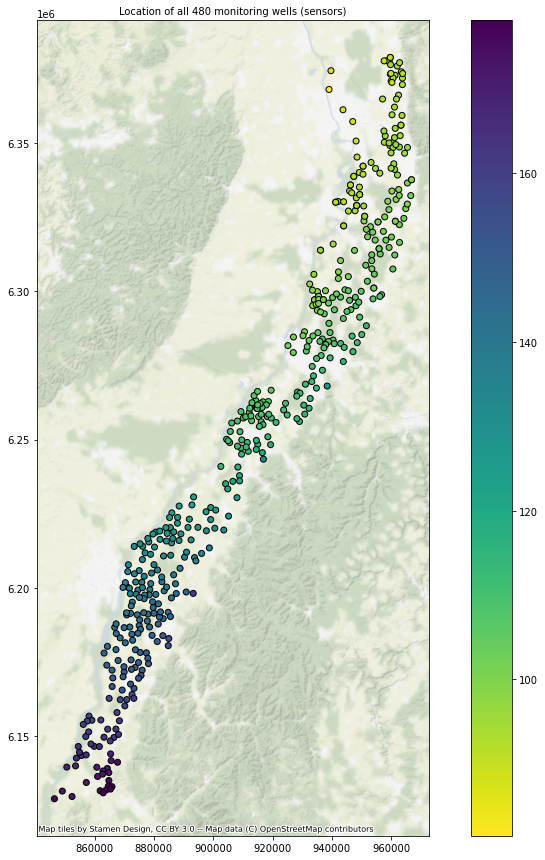

In [6]:
#Plot all sensor locations
f, ax = plt.subplots(1, figsize=(15, 15))

plt.plot(ax=ax,color='gray',alpha=0.25, edgecolor='k')
fig = gdf2.plot(ax=ax,column='MEAN_GWL',cmap='viridis_r',edgecolor='k',legend=True)
ax.set_title('Location of all 480 monitoring wells (sensors)', size=10 )
ctx.add_basemap(ax, source=ctx.providers.Stamen.TerrainBackground, alpha=0.5)
plt.show()

Create X-array from dataframe

In [7]:
#Dataframe in Array umwandeln
X=df.to_numpy()
n_samples, n_features = X.shape
xmin,xmax = X.min(), X.max()

print ('Sampling period: ', df.T.columns[1] , df.T.columns[-1])
print('Number of samples:', n_samples)
print('Number of features (sensors):', n_features)
print('Shape of X (samples, sensors):', X.shape)
print ('Min. and max. value: ', xmin, unit , ' ; ', xmax,  unit )

Sampling period:  1990-01-15 00:00:00 2014-12-29 00:00:00
Number of samples: 1304
Number of features (sensors): 480
Shape of X (samples, sensors): (1304, 480)
Min. and max. value:  79.81 [m]  ;  180.05 [m]


Centering the data

In [8]:
# Global centering
x_gc=X.mean(axis=0)
X = X - x_gc

# Local centering
x_lc = X.mean(axis=1).reshape(n_samples, -1)
X = X - x_lc

print ('Min. and max. centered value: ', X.min().round(3), unit, X.max().round(3),  unit )
print ('Mean centered data: ', X.mean().round(5), unit )

Min. and max. centered value:  -2.622 [m] 3.667 [m]
Mean centered data:  -0.0 [m]


Train and test split (80/20)

In [9]:
# Train and Test data
tdata = int(len(X)*0.8)
X_train, X_test = X[:tdata], X[tdata:]

print('Train data:', len(X_train), ', Test data:', len(X_test)) 
print('Train data:', round(((tdata/len(X))*100)), '%', ', Test data:', 100-round(((tdata/len(X))*100)), '%')

Train data: 1043 , Test data: 261
Train data: 80 % , Test data: 20 %


# GWM Ranking

In [10]:
model = ps.SSPOR(
     basis=ps.basis.Identity(),
     n_sensors= n_features).fit(X_train,seed=seed)
model

SSPOR(basis=Identity(n_basis_modes=1043), n_sensors=480, optimizer=QR())

In [11]:
# Get the chosen wells
sensors_all = model.get_selected_sensors()

# Creates translation
s = sensors_all.tolist()
s = pd.DataFrame(s,columns=['sensors'])

# Merge sensor list and key
sensors_ID= pd.merge(s, key, left_on='sensors', right_on='sensors', how='left')
sensors_ID.insert(0,'rank', range(1, 1+len(sensors_ID)))
sensors_ID.set_index('rank', inplace=True,drop=False)

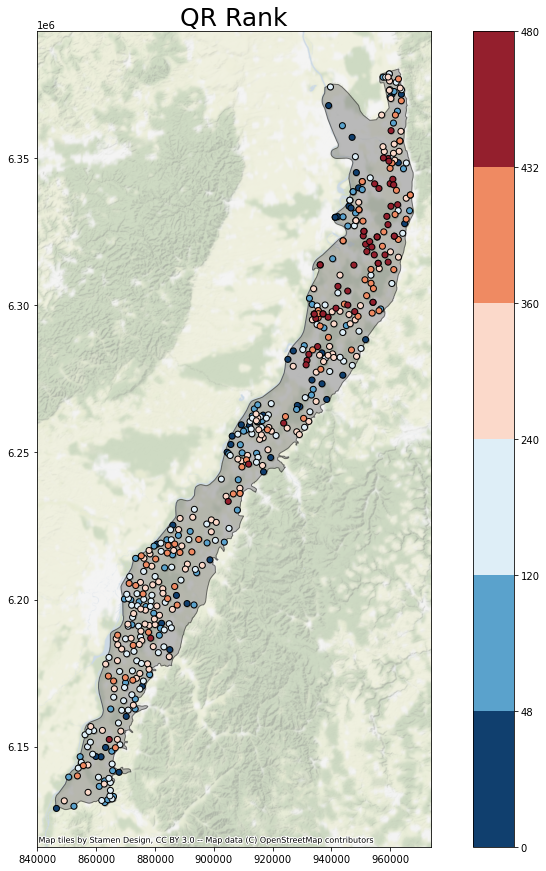

In [12]:
# Define color range
bounds= [int(n_features*0), int(n_features*0.1), int(n_features*0.25), int(n_features*0.5),int(n_features*0.75),int(n_features*0.9), int(n_features*1)]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#103F6E","#5AA2CC","#DEEEF7","#FBD9CA","#EF8A62","#941F2D"])
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

#create gdf of best sensors based on error
gdf3= pd.merge(gdf2, sensors_ID, left_on='GW_Nummer', right_on='GW_Nummer', sort=False, how='right').to_crs(epsg=3857)

#Plot Ranking
f, ax = plt.subplots(1, figsize=(15, 15))
gdf.plot(ax=ax,color='gray',alpha=0.5, edgecolor='k')
gdf2.plot(ax=ax,color='black', alpha=0.15)
gdf3.plot(ax=ax,column='rank',cmap=cmap,  norm=norm ,edgecolor='k',legend=True)
ax.set_title('QR Rank', size=25 )
ctx.add_basemap(ax, source=ctx.providers.Stamen.TerrainBackground, alpha=0.5)
plt.show()

## GMN Reduction

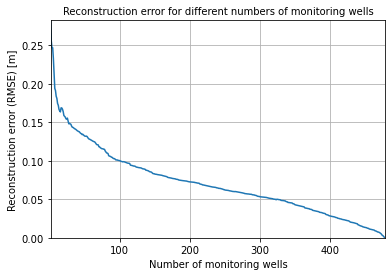

In [13]:
#RMSE as function of n wells
sensor_range = np.arange(1, n_features, 1)
errors = model.reconstruction_error(X_test, sensor_range=sensor_range)

plt.plot(sensor_range, errors, color='tab:blue', linestyle='-', marker='')
plt.xlabel('Number of monitoring wells')
plt.ylabel('Reconstruction error (RMSE) '+str(unit))
plt.title('Reconstruction error for different numbers of monitoring wells', size=10)
plt.autoscale(enable=True, axis='x', tight=True)
plt.autoscale(enable=True, axis='y', tight=True)
plt.grid(True)
plt.show()

## Define Reduction

In [14]:
# Defin desired monitoring network reduction in [%]
#reduction = 25 #[%]

n_sensors = int(n_features -((reduction*n_features)/100))

print("wells removed", int(n_features-n_sensors))
print("wells remaining", n_sensors)

wells removed 384
wells remaining 96


## Reconstruction

In [15]:
# Set number of sensors after fitting
model.set_number_of_sensors(n_sensors)
print(model)
sensors = model.get_selected_sensors()

SSPOR(basis=Identity(n_basis_modes=1043), n_sensors=96, optimizer=QR())


In [16]:
# Subsample data so we only have measurements at chosen sensor locations
X_test_subsampled = X_test[:, sensors]; X_train_subsampled = X_train[:, sensors]

# Form reconstructions
X_test_reconstructed = model.predict(X_test_subsampled); X_train_reconstructed = model.predict(X_train_subsampled)

In [17]:
#Rescaling
X = np.append(X_train, X_test, axis=0)
X += x_lc # local rescale
X += x_gc  # global rescale
X_train, X_test = X[:tdata], X[tdata:]

X_reconstructed= np.append(X_train_reconstructed, X_test_reconstructed, axis=0) # appending in one array
X_reconstructed+= x_lc # local rescale
X_reconstructed+= x_gc # global rescale

X_train_reconstructed, X_test_reconstructed = X_reconstructed[:tdata], X_reconstructed[tdata:] # splitting in train and test set

In [18]:
#Rename Index and columns 
# recon = reconstructed data; obs = observed data
recon= pd.DataFrame(X_test_reconstructed)
recon.columns=df.columns
obs=df[len(X_train):len(df)]
recon.index=obs.index

# Creates translation
s_red = sensors.tolist()
s_red = pd.DataFrame(s_red,columns=['sensors'])

# Merge sensor list and key
sensors_ID_red= pd.merge(s_red, key, left_on='sensors', right_on='sensors', how='left')
sensors_ID_red.insert(0,'rank', range(1, 1+len(sensors)))
sensors_ID_red.set_index('rank', inplace=True,drop=False)

#Rename columns
recon=recon.T
recon= pd.merge(recon, key, left_on='sensors', right_on='sensors', how='left')
recon.set_index('GW_Nummer', inplace=True,drop=True)
recon=recon.T

obs=obs.T
obs= pd.merge(obs, key, left_on='sensors', right_on='sensors', how='left')
obs.set_index('GW_Nummer', inplace=True,drop=True)
obs=obs.T

In [19]:
#Filtering sensors used
sensor_list=list(sensors_ID_red.GW_Nummer)

#redundant
recon_red=recon.drop(sensor_list, axis = 1)
obs_red=obs.drop((sensor_list), axis = 1)
#optimal
recon_opt=recon.filter(sensor_list)
obs_opt=obs.filter(sensor_list)

## Results

### Get error scores

In [20]:
err = recon_red-obs_red
err_rel = err/((np.max(obs_red)-np.min(obs_red)))
err_nash = obs_red - np.mean(obs_red)
MAE = np.mean(abs(err))
NSE = 1 - ((np.sum(err ** 2)) / (np.sum((err_nash) ** 2)))  
r=recon_red.corrwith(obs_red, axis = 0)
R2=r ** 2
RMSE =  np.sqrt(np.mean(err ** 2))
rRMSE = np.sqrt(np.mean(err_rel ** 2)) * 100
Bias = np.mean(err)
rBias = np.mean(err_rel) * 100
alpha = np.std(recon_red)/np.std(obs_red)
beta = np.mean(recon_red)/np.mean(obs_red)
KGE = 1-np.sqrt((r-1)**2+(alpha-1)**2+(beta-1)**2)

scores = pd.DataFrame({'MAE': MAE, 'NSE' : NSE, 'R2': R2, 'RMSE' : RMSE, 'rRMSE' :  rRMSE, 'Bias' : Bias, 'rBias' : rBias, 'KGE' : KGE, 'alpha': alpha, 'beta': beta, 'r_score' :r})

### Ploting hydrograph reconstrucion

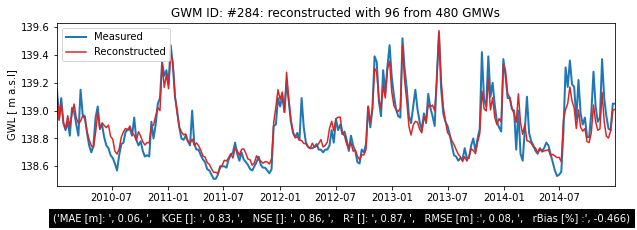

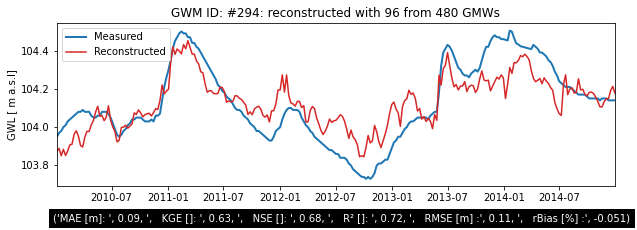

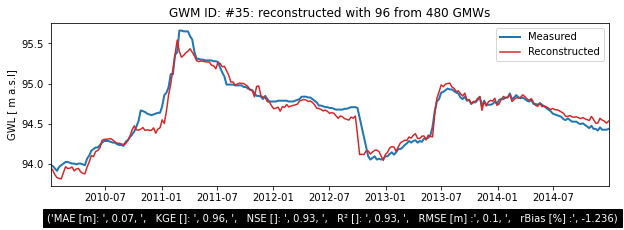

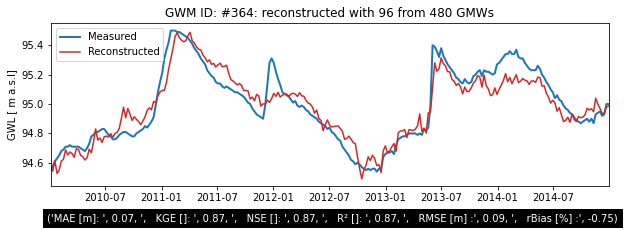

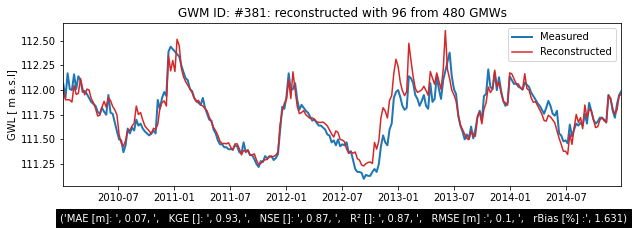

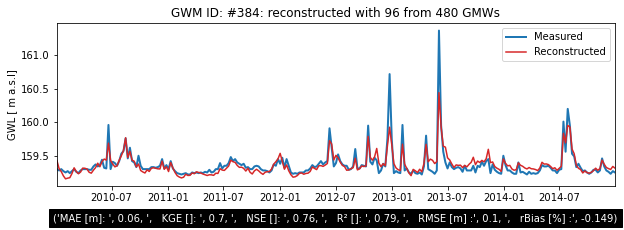

In [24]:
plt.rcParams['figure.figsize'] = [10,3]
# Plot reconstuction

for i in sorted(list(recon_red.columns.values)):
    plt.plot(obs_red[i],'-', color='tab:blue',linewidth=2)
    plt.plot(recon_red[i],'-', color='tab:red',linewidth=1.5)
    plt.legend(labels=['Measured','Reconstructed'])
    plt.title('GWM ID: '+str(i)+': reconstructed with '+ str(n_sensors)+ ' from '+ str(n_features)+ ' GMWs', fontsize=12)
    plt.ylabel('GWL [ m a.s.l]')
    plt.autoscale(enable=True, axis='x', tight=True)
    textstr1='MAE [m]: ', scores.MAE[i].round(2),',   KGE []: ', scores.KGE[i].round(2),',   NSE []: ', scores.NSE[i].round(2),',   R² []: ', scores.R2[i].round(2),',   RMSE [m] :', scores.RMSE[i].round(2), ',   rBias [%] :', scores.rBias[i].round(3)
    plt.figtext(0.12, -0.035, textstr1, color='white', fontsize=10, bbox={'fc':'black','ec':'black'})
    plt.show()

MAE : 0.08 [m]   RMSE : 0.11 [m]   rBias: -0.05 [%]   NSE: 0.8 []   R2: 0.83 []   KGE: 0.85 []


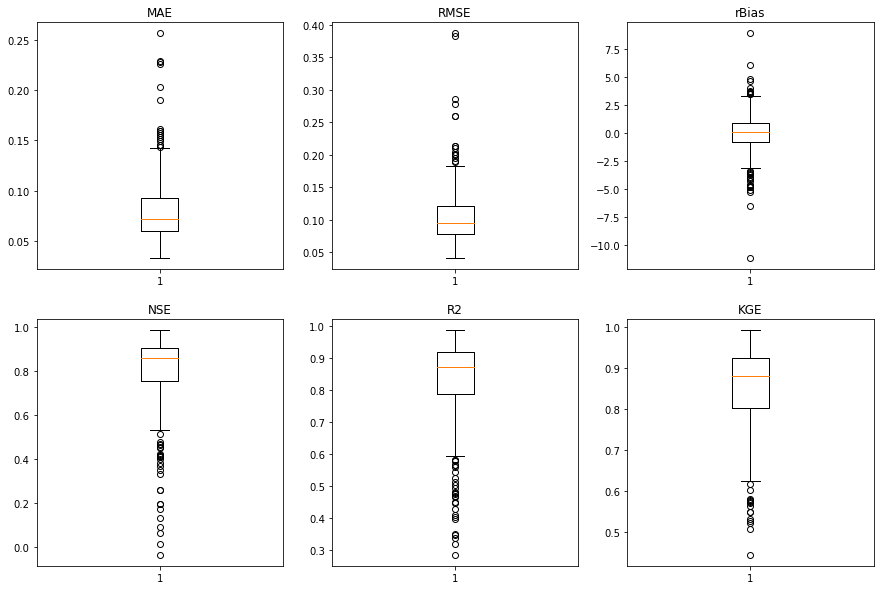

In [25]:

#Boxplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
# MAE
axs[0, 0].boxplot(MAE)
axs[0, 0].set_title('MAE')
# RMSE
axs[0, 1].boxplot(RMSE)
axs[0, 1].set_title('RMSE')
# rBias
axs[0, 2].boxplot(rBias)
axs[0, 2].set_title('rBias')
# NSE
axs[1, 0].boxplot(NSE)
axs[1, 0].set_title('NSE')
# R2
axs[1, 1].boxplot(R2)
axs[1, 1].set_title('R2')
# KGE
axs[1, 2].boxplot(KGE)
axs[1, 2].set_title('KGE')
print("MAE :",MAE.mean().round(2), unit, "  RMSE :", RMSE.mean().round(2), unit,"  rBias:", rBias.mean().round(2), '[%]',"  NSE:", NSE.mean().round(2), '[]',"  R2:", R2.mean().round(2), '[]', "  KGE:", KGE.mean().round(2), '[]')

In [26]:
#Get rank depending on error
s1= abs(obs-recon).mean().sort_values(ascending=False)
s1=s1[:(n_features-n_sensors)]
rank=pd.DataFrame(s1, columns=['error']).sort_values(by=['error'])

rank.insert(0,'error_rank', range(1, 1+len(rank)))
rank.reset_index(level=0, inplace=True)
rank.set_index('error_rank', inplace=True, drop=False)

#create gdf of best sensors based on error
gdf4= pd.merge(gdf2, rank, left_on='GW_Nummer', right_on='GW_Nummer', sort=False, how='right').to_crs(epsg=3857)

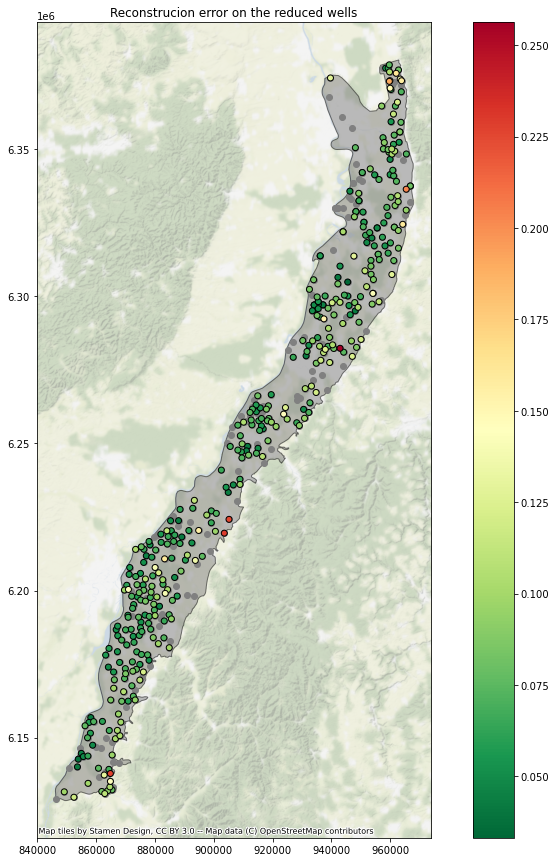

In [27]:
#Plot Ranking
f, ax = plt.subplots(1, figsize=(15, 15))

gdf.plot(ax=ax,color='gray',alpha=0.5, edgecolor='k')
gdf2.plot(ax=ax,color='grey', alpha=1)
gdf4.plot(ax=ax,column='error',cmap='RdYlGn_r',edgecolor='k',legend=True)
ax.set_title('Reconstrucion error on the reduced wells', size=12 )
ctx.add_basemap(ax, source=ctx.providers.Stamen.TerrainBackground, alpha=0.5)
plt.show()
